In [1]:
import calendar
import datetime as dt
import dateutil.parser as dp
import gspread
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from IPython.display import display
from functools import partial
from oauth2client.service_account import ServiceAccountCredentials

# Setting up key, token and Service Account

In [2]:
with open('keys.json') as file:
    keys = json.load(file)
    api_key = keys['trello']['api_key']
    token = keys['trello']['token']
    spreadsheet_key = keys['sheet']['spreadsheet_key']
    sa_file = keys['sheet']['sa_file']

# Extracting Sheet Data

In [3]:
def convert_sheet_date(sheet_date):
    conversion_table = {
        'January': '01',
        'February': '02',
        'March': '03',
        'April': '04',
        'May': '05',
        'June': '06',
        'July': '07',
        'August': '08',
        'September': '09',
        'October': '10',
        'November': '11',
        'December': '12'
    }
    
    month = conversion_table[sheet_date.split('-')[0].strip()]
    year = sheet_date.split('-')[1].strip()
    
    return year + '-' + month

In [4]:
def get_consolidated_sheet():
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(sa_file, scope) 
    gc = gspread.authorize(credentials)
    
    book = gc.open_by_key(spreadsheet_key)
    worksheet = book.worksheet("Consolidated")
    table = worksheet.get_all_values()
    
    return table

In [5]:
def get_total_by_date():
    table = get_consolidated_sheet()
    
    header_row = table[0]
    columns = [value for index, value in enumerate(header_row) if value] 
    converted_columns = [ convert_sheet_date(x) for x in columns[1:]]
    
    total_row = table[14]
    # getting only the executed column
    total = [value for index, value in enumerate(total_row) if index % 3 == 0]
    total.pop(0)
    
    total_by_date = [ [converted_columns[index], value] for index, value in enumerate(total)]
    
    return total_by_date

In [6]:
def create_ftes_dataframe():
    # from deprecated sheet, it will never be changed
    old_data = [
        ['2020-03', 4.0],
        ['2020-04', 6.15],
        ['2020-05', 6.25],
        ['2020-06', 6.0],
        ['2020-07', 3.65],
        ['2020-08', 4.57],
        ['2020-09', 4.52],
        ['2020-10', 4.9],
        ['2020-11', 4.7]
    ]
    
    new_data = get_total_by_date()
    
    full_data = old_data + new_data
    
    total_fte = pd.DataFrame(full_data, columns=['month_base', 'fte'])
    
    total_fte['month_base'] = pd.to_datetime(total_fte['month_base'])
    total_fte['month'] = pd.PeriodIndex(total_fte['month_base'], freq='M')
    total_fte['quarter'] = pd.PeriodIndex(total_fte['month_base'], freq='Q')
    total_fte['fte'] = total_fte['fte'].astype(float)
    
    del total_fte['month_base']
    
    return total_fte

In [7]:
total_fte = create_ftes_dataframe()

In [8]:
total_fte

,fte,month,quarter
0,4.00,2020-03,2020Q1
1,6.15,2020-04,2020Q2
2,6.25,2020-05,2020Q2
3,6.00,2020-06,2020Q2
4,3.65,2020-07,2020Q3
5,4.57,2020-08,2020Q3
6,4.52,2020-09,2020Q3
7,4.90,2020-10,2020Q4
8,4.70,2020-11,2020Q4
9,4.90,2020-12,2020Q4


# Extracting Trello Data

In [9]:
def get_data_from_trello_api(url):
    headers = {
       "Accept": "application/json"
    }
    
    query = {
       'key': api_key,
       'token': token
    }
    
    response = requests.request("GET", url, headers=headers, params=query)
    
    if response.status_code > 299:
        raise Exception('Something went wrong with the request {0} '\
                        'with status: {1}'.format(url, response.status_code))
    
    return json.loads(response.text)

In [10]:
def get_all_boards():
    boards_url = "https://api.trello.com/1/members/me/boards"
    
    boards = get_data_from_trello_api(boards_url)
    
    return boards

In [11]:
def get_board_by_name(board_name):
    boards_url = "https://api.trello.com/1/search?query=CBN"
    query = get_data_from_trello_api(boards_url)
    cbn_board = query["boards"][0]
    
    
    return cbn_board

In [12]:
def get_lists_by_board(id_board):
    lists_url = 'https://api.trello.com/1/boards/{0}/lists'
    
    lists = get_data_from_trello_api(lists_url.format(id_board))
    
    
    list_map = {}
    for list in lists:
        list_map[list['id']] = list['name']
    
    return list_map

In [13]:
def get_custom_fields_by_board(id_board):
    custom_fields = 'https://api.trello.com/1/boards/{0}/customFields'
    
    custom_fields = get_data_from_trello_api(custom_fields.format(id_board))
    
    custom_field_map = {}
    for custom_field in custom_fields:
        custom_field_map[custom_field['id']] = custom_field['name']
    
    return custom_field_map

In [14]:
def get_cards_by_board(id_board):
    
    name_of_dump = create_raw_dump()
    
    with open(name_of_dump) as file:
        
        cards_raw = json.load(file)
        
        fields = ("id", "name", "idList", "shortUrl", "customFieldItems")

        cards = [{key : value for key, value in card.items() if key in fields} for card in cards_raw ]

        custom_fields_map = get_custom_fields_by_board(id_board)

        lists_map = get_lists_by_board(id_board)
        #cards = get_data_from_trello_api(cards_on_board_url.format(id_board))


        useful_cards = []
        for card in cards:
            idListName = lists_map[card['idList']]
            if idListName in ['Done']:
                normalized_card = {}

                for custom_field in card['customFieldItems']:
                    name = custom_fields_map[custom_field['idCustomField']]
                    if name in ['Start', 'End', 'EndDev']:
                        value = custom_field['value']['date']
                        normalized_card[name] = value

                if len(normalized_card) < 3:
                    raise Exception(
                        'Make sure all dates are filled in the card: Start, EndDev and End for {0}'.format(card['name']))

                normalized_card['name'] = card['name']
                normalized_card['shortUrl'] = card['shortUrl']
                normalized_card['idList'] = lists_map[card['idList']]
                useful_cards.append(normalized_card)
    
    
    
    return useful_cards

In [15]:
def create_dataframe_from_trello_api():
    cbn_board = get_board_by_name('CBN')
    cards = get_cards_by_board(cbn_board['id'])
    df = pd.DataFrame.from_dict(cards)

    df['dev_duration'] = (pd.to_datetime(df['EndDev']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    df['duration'] = (pd.to_datetime(df['End']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    
    df['busday_dev_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['EndDev']).dt.date)
    
    df['busday_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['End']).dt.date)
    
    df['quarter'] = pd.PeriodIndex(df['End'], freq='Q')
    
    df['month'] = pd.PeriodIndex(df['End'], freq='M')

    df["count"] = 1
    
    return df

In [16]:
def create_raw_dump():
    cbn_board = get_board_by_name('CBN')
    cbn_board_id = cbn_board["id"]
    
    cards_on_board_url = f'https://api.trello.com/1/boards/{cbn_board_id}/cards/?customFieldItems=true'
    board_cards = get_data_from_trello_api(cards_on_board_url)
    
    time_now = dt.datetime.now().strftime("%d-%m-%Y")
    
    name_of_dump = f"dumps/raw_cards_CBN_{time_now}.json"
    
    with open(name_of_dump, "w") as json_file:
        json.dump(board_cards, json_file)
        
    return name_of_dump

In [17]:
def create_filtered_dump():
    cbn_board = get_board_by_name('CBN')
    cbn_board_id = cbn_board["id"]
    
    cards_on_board_url = f'https://api.trello.com/1/boards/{cbn_board_id}/cards/?fields=id,name,idList,shortUrl&customFieldItems=true'
    board_cards = get_data_from_trello_api(cards_on_board_url)
    
    time_now = dt.datetime.now().strftime("%d-%m-%Y")
    
    name_of_dump = f"dumps/filtered_dumps/filtered_cards_CBN_{time_now}.json"
    
    with open(name_of_dump, "w") as json_file:
        json.dump(board_cards, json_file)
        
    return name_of_dump

In [18]:
pd.set_option('display.max_rows', None)
df = create_dataframe_from_trello_api()

In [19]:
df

,EndDev,End,Start,name,shortUrl,idList,dev_duration,duration,busday_dev_duration,busday_duration,quarter,month,count
0,2021-04-23T16:22:00.000Z,2021-04-28T14:39:21.000Z,2021-04-08T14:21:58.000Z,CHROME_MANAGEMENT,https://trello.com/c/shbjiq1I,Done,15,20,11,14,2021Q2,2021-04,1
1,2021-04-13T18:11:55.000Z,2021-04-21T03:55:43.000Z,2021-04-08T20:12:47.000Z,CITRIX_STOREFRONT (FIX),https://trello.com/c/Y0n7hbWQ,Done,5,13,3,9,2021Q2,2021-04,1
2,2021-04-15T16:51:10.000Z,2021-04-20T13:05:12.000Z,2021-04-05T13:35:45.000Z,UMBRELLA_DNS,https://trello.com/c/Xp8XOqkL,Done,10,15,8,11,2021Q2,2021-04,1
3,2021-04-14T16:12:02.000Z,2021-04-14T18:40:11.000Z,2021-04-12T16:19:56.000Z,GCP_COMPUTE_CONTEXT(Fix asset.labels),https://trello.com/c/cSrABCLt,Done,2,2,2,2,2021Q2,2021-04,1
4,2021-04-08T20:12:00.000Z,2021-04-14T17:15:26.000Z,2021-03-30T14:00:43.000Z,CUSTOM_SECURITY_DATA_ANALYTICS,https://trello.com/c/Lq7zynS9,Done,9,15,7,11,2021Q2,2021-04,1
5,2021-04-12T17:52:09.000Z,2021-04-14T15:00:00.000Z,2021-03-08T18:45:29.000Z,SEP parser fix for issue 175012748,https://trello.com/c/wA3LOrDt,Done,35,37,25,27,2021Q2,2021-04,1
6,2021-04-09T22:12:45.000Z,2021-04-12T15:00:00.000Z,2021-03-26T16:39:16.000Z,MYSQL,https://trello.com/c/mkPn5AXD,Done,14,17,10,11,2021Q2,2021-04,1
7,2021-04-09T13:12:15.000Z,2021-04-12T15:00:00.000Z,2021-03-11T18:44:57.000Z,CIS_ALBERT_ALERTS,https://trello.com/c/3BvQhngN,Done,29,32,21,22,2021Q2,2021-04,1
8,2021-04-05T19:51:25.000Z,2021-04-08T15:00:00.000Z,2021-03-30T17:33:17.000Z,GCP_DNS,https://trello.com/c/v84YzTSY,Done,6,9,4,7,2021Q2,2021-04,1
9,2021-04-05T20:00:11.000Z,2021-04-08T15:00:00.000Z,2021-03-12T13:41:59.000Z,MIMECAST_MAIL fix core identity,https://trello.com/c/Sdsiev0E,Done,24,27,16,19,2021Q2,2021-04,1


In [20]:
cancelled = df[(df["idList"] == "Cancelled")]
done = df[(df["idList"] == "Done")]

# Joining both fte and parsers tables

# Calculating General Estimatives

# Functions

In [21]:
def get_extremes(data_frame, duration_column):
    upper_q = partial(pd.Series.quantile, q=0.95)
    lower_q = partial(pd.Series.quantile, q=0.05)

    upper_extremes = data_frame[duration_column].agg([upper_q])["quantile"]
    lower_extremes = data_frame[duration_column].agg([lower_q])["quantile"]
    
    return lower_extremes, upper_extremes

In [22]:
def calculate_estimatives_by_duration_column(data_frame, duration_column, print_results=True):
    lower_extremes, upper_extremes = get_extremes(data_frame, duration_column)
    
    done_extremes_removed = data_frame[(data_frame[duration_column] > lower_extremes) & (data_frame[duration_column] < upper_extremes)]
    mean_removed_extremes = done_extremes_removed[duration_column].mean()
    
    small_q = partial(pd.Series.quantile, q=0.25)
    small_limit = done_extremes_removed[duration_column].agg([small_q])["quantile"]
    
    small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] <= small_limit)]
    not_small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] > small_limit)]
    
    mean_small_extremes_removed = small_extremes_removed[duration_column].mean()
    mean_not_small_extremes_removed = not_small_extremes_removed[duration_column].mean()
    
    total_developed = len(data_frame)
    
    if print_results:
        print('lower_extremes ->', lower_extremes)
        print('upper_extremes ->', upper_extremes)
        print('small limit ->', small_limit)
        print('Done estimate (with "extremes" removed) ->', mean_removed_extremes)
        print('Done estimate for "Small" ones ->', mean_small_extremes_removed)
        print('Done estimate for "Big" ones ->', mean_not_small_extremes_removed)
        print('Total_developed ->', total_developed)

    return done_extremes_removed
    
    

In [23]:
def calculate_estimatives(data_frame):
    print('Total Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'duration')
    print('\n')
    print('Total Dev Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'dev_duration')
    print('\n')
    print('##############')
    print('#BUSINESS DAY#')
    print('##############')
    print('\n')
    print('Business Day Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'busday_duration')
    print('\n')
    print('Business Day Dev Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'busday_dev_duration')
    

In [24]:
def generate_tables_and_charts(data_frame, duration_column, print_tables, plot_charts):
    df1 = data_frame[[duration_column, 'quarter']].groupby('quarter').mean()
    df2 = data_frame[['quarter', 'count']].groupby('quarter').sum('count')
    df3 = data_frame[['month', 'count']].groupby('month').sum('count')
    
    if print_tables:
        display(df1)
        display(df2)
        display(df3)
    
    if plot_charts:
        df1.plot()
        df2.plot()
        df3.plot()


In [25]:
def generate_tables_and_charts_by_duration_colum(data_frame, duration_column, remove_extremes):
    if remove_extremes:
        df_with_no_extremes = calculate_estimatives_by_duration_column(data_frame, duration_column, False)
        generate_tables_and_charts(df_with_no_extremes, duration_column, True, True)
    else:
        generate_tables_and_charts(data_frame, duration_column, True, True)
    

In [26]:
def generate_full_duration_table_and_chart(data_frame, period): # quarter or month
    new_df = data_frame[['dev_duration', 'duration', 'busday_dev_duration', 'busday_duration', period]]
    new_df = new_df.groupby(period).mean()
    display(new_df)
    new_df.plot()

# General Estimatives

In [27]:
calculate_estimatives(done)

Total Duration:


lower_extremes -> 1.0
upper_extremes -> 52.54999999999998
small limit -> 12.75
Done estimate (with "extremes" removed) -> 19.193181818181817
Done estimate for "Small" ones -> 7.636363636363637
Done estimate for "Big" ones -> 23.045454545454547
Total_developed -> 104


Total Dev Duration:


lower_extremes -> 0.0
upper_extremes -> 43.49999999999994
small limit -> 7.0
Done estimate (with "extremes" removed) -> 13.31868131868132
Done estimate for "Small" ones -> 4.230769230769231
Done estimate for "Big" ones -> 16.953846153846154
Total_developed -> 104


##############
#BUSINESS DAY#
##############


Business Day Duration:


lower_extremes -> 1.0
upper_extremes -> 36.849999999999994
small limit -> 10.0
Done estimate (with "extremes" removed) -> 13.873563218390805
Done estimate for "Small" ones -> 6.9
Done estimate for "Big" ones -> 17.54385964912281
Total_developed -> 104


Business Day Dev Duration:


lower_extremes -> 0.0
upper_extremes -> 30.94999999999996
small limit 

# Duration time

In [28]:
df1 = df.copy()

,dev_duration,duration,busday_dev_duration,busday_duration
quarter,,,,
2020Q1,7.000000,12.500000,5.000000,9.500000
2020Q2,12.250000,16.666667,8.666667,11.916667
2020Q3,14.000000,16.428571,10.000000,11.761905
2020Q4,15.650000,22.550000,11.350000,16.250000
2021Q1,18.160000,25.720000,12.960000,18.360000
2021Q2,13.416667,18.083333,9.583333,12.750000


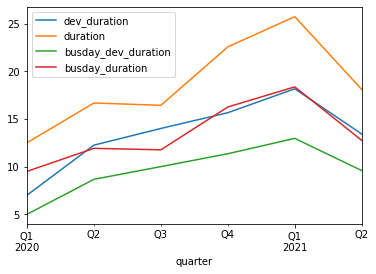

In [29]:
generate_full_duration_table_and_chart(df1, 'quarter')

,dev_duration,duration,busday_dev_duration,busday_duration
month,,,,
2020-03,7.000000,12.500000,5.000000,9.500000
2020-04,12.000000,19.666667,8.666667,14.333333
2020-05,17.666667,22.500000,12.333333,16.166667
2020-06,10.133333,13.733333,7.200000,9.733333
2020-07,6.818182,9.090909,4.818182,6.545455
2020-08,26.000000,28.750000,18.500000,20.250000
2020-09,19.166667,21.666667,13.833333,15.666667
2020-10,24.333333,33.000000,17.000000,23.666667
2020-11,12.600000,20.100000,9.400000,14.700000


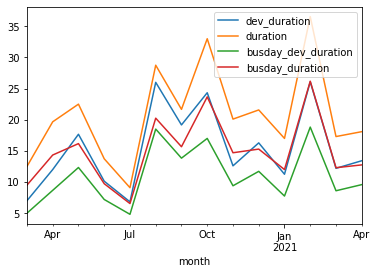

In [30]:
generate_full_duration_table_and_chart(df1, 'month')

# Duration Time without extremes

In [31]:
df2 = df.copy()
df2 = calculate_estimatives_by_duration_column(df2, 'duration', False)

,dev_duration,duration,busday_dev_duration,busday_duration
quarter,,,,
2020Q1,7.000000,12.500000,5.000000,9.500000
2020Q2,13.952381,18.952381,9.857143,13.523810
2020Q3,15.266667,18.133333,10.866667,12.933333
2020Q4,15.705882,23.352941,11.470588,16.882353
2021Q1,12.619048,18.095238,8.904762,12.857143
2021Q2,13.416667,18.083333,9.583333,12.750000


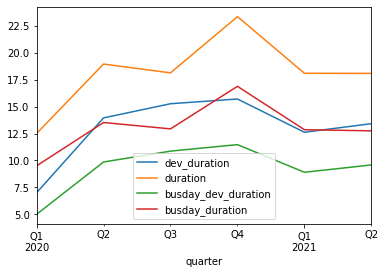

In [32]:
generate_full_duration_table_and_chart(df2, 'quarter')

,dev_duration,duration,busday_dev_duration,busday_duration
month,,,,
2020-03,7.000000,12.500000,5.000000,9.500000
2020-04,12.000000,19.666667,8.666667,14.333333
2020-05,17.666667,22.500000,12.333333,16.166667
2020-06,12.583333,17.000000,8.916667,12.000000
2020-07,12.000000,15.833333,8.333333,11.166667
2020-08,14.000000,15.666667,10.000000,11.000000
2020-09,19.166667,21.666667,13.833333,15.666667
2020-10,24.333333,33.000000,17.000000,23.666667
2020-11,14.000000,22.222222,10.444444,16.222222


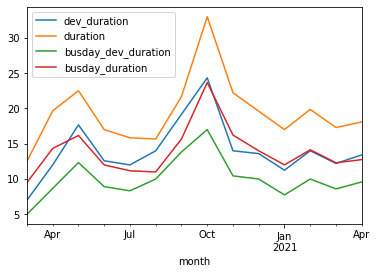

In [33]:
generate_full_duration_table_and_chart(df2, 'month')

# Amount delivered by month

<AxesSubplot:xlabel='month'>

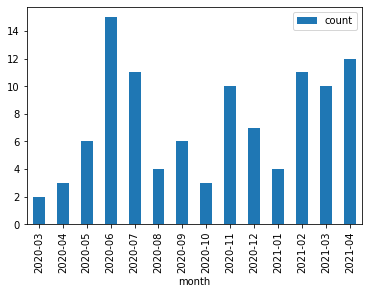

In [34]:
df[['month', 'count']].groupby('month').sum('count').plot(kind='bar')

<AxesSubplot:xlabel='month'>

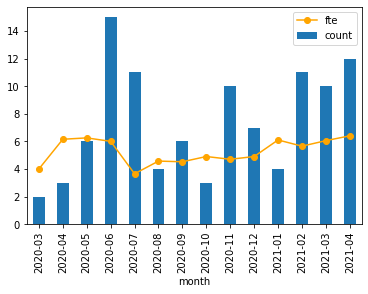

In [35]:
by_month = df[['month', 'count']].groupby('month').sum('count')

monthly_result = pd.merge(by_month, total_fte, on='month', how='left')

monthly_result['month'] = monthly_result['month'].astype(str)

ax = monthly_result[['month','fte']].plot(x='month', linestyle='-', marker='o', color='orange')
monthly_result[['month','count']].plot(x='month', kind='bar', ax=ax)

In [36]:
monthly_result

,month,count,fte,quarter
0,2020-03,2,4.00,2020Q1
1,2020-04,3,6.15,2020Q2
2,2020-05,6,6.25,2020Q2
3,2020-06,15,6.00,2020Q2
4,2020-07,11,3.65,2020Q3
5,2020-08,4,4.57,2020Q3
6,2020-09,6,4.52,2020Q3
7,2020-10,3,4.90,2020Q4
8,2020-11,10,4.70,2020Q4
9,2020-12,7,4.90,2020Q4


# Amount delivered by quarter

<AxesSubplot:xlabel='quarter'>

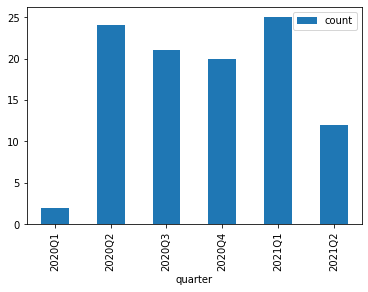

In [37]:
df[['quarter', 'count']].groupby('quarter').sum('count').plot(kind='bar')

<AxesSubplot:xlabel='quarter'>

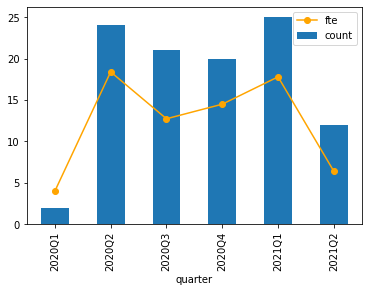

In [38]:
by_quarter = df[['quarter', 'count']].groupby('quarter').sum('count')

by_quarter_fte = pd.merge(by_quarter, total_fte, on='quarter', how='left')

quartly_result = by_quarter_fte[['quarter', 'count', 'fte']].groupby(['quarter','count']).sum('fte')
quartly_result.reset_index(drop=False, inplace=True)

quartly_result['quarter'] = quartly_result['quarter'].astype(str)

ax = quartly_result[['quarter','fte']].plot(x='quarter', linestyle='-', marker='o', color='orange')
quartly_result[['quarter','count']].plot(x='quarter', kind='bar', ax=ax)

In [39]:
quartly_result

,quarter,count,fte
0,2020Q1,2,4.00
1,2020Q2,24,18.40
2,2020Q3,21,12.74
3,2020Q4,20,14.50
4,2021Q1,25,17.80
5,2021Q2,12,6.40


# Data for business days

,busday_duration
quarter,
2020Q1,9.500000
2020Q2,14.200000
2020Q3,12.933333
2020Q4,16.882353
2021Q1,12.857143
2021Q2,12.750000


,count
quarter,
2020Q1,2
2020Q2,20
2020Q3,15
2020Q4,17
2021Q1,21
2021Q2,12


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,11
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


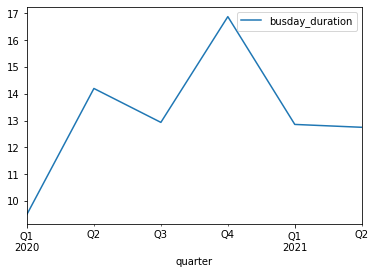

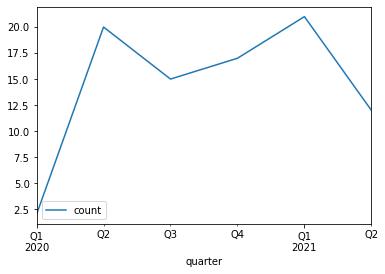

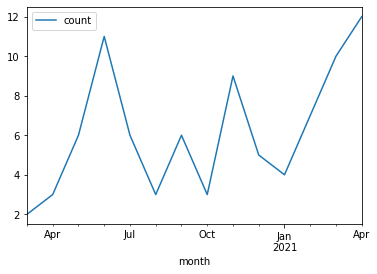

In [40]:
generate_tables_and_charts_by_duration_colum(df, 'busday_duration', True)

,busday_duration
quarter,
2020Q1,9.500000
2020Q2,11.916667
2020Q3,11.761905
2020Q4,16.250000
2021Q1,18.360000
2021Q2,12.750000


,count
quarter,
2020Q1,2
2020Q2,24
2020Q3,21
2020Q4,20
2021Q1,25
2021Q2,12


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,15
2020-07,11
2020-08,4
2020-09,6
2020-10,3
2020-11,10


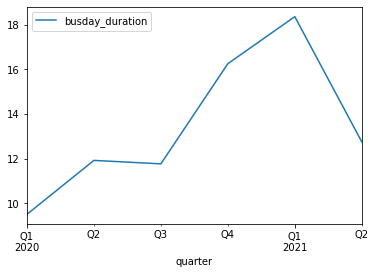

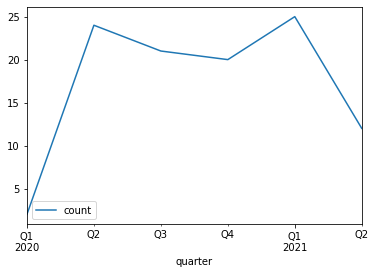

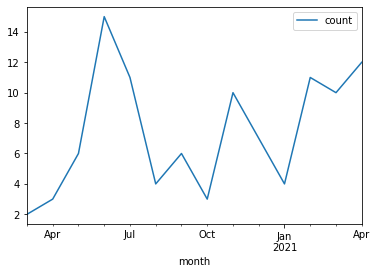

In [41]:
generate_tables_and_charts_by_duration_colum(df, 'busday_duration', False)

# Data for duration days

,duration
quarter,
2020Q1,12.500000
2020Q2,18.952381
2020Q3,18.133333
2020Q4,23.352941
2021Q1,18.095238
2021Q2,18.083333


,count
quarter,
2020Q1,2
2020Q2,21
2020Q3,15
2020Q4,17
2021Q1,21
2021Q2,12


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,12
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


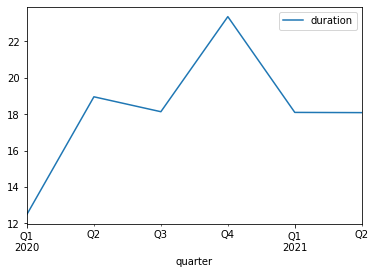

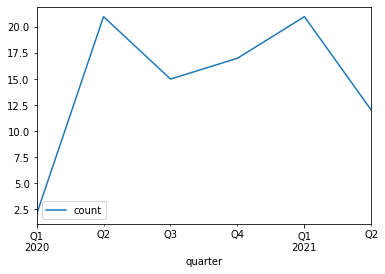

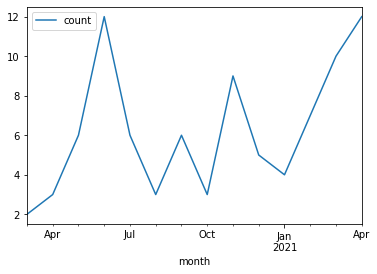

In [42]:
generate_tables_and_charts_by_duration_colum(df, 'duration', True)

,duration
quarter,
2020Q1,12.500000
2020Q2,18.952381
2020Q3,18.133333
2020Q4,23.352941
2021Q1,18.095238
2021Q2,18.083333


,count
quarter,
2020Q1,2
2020Q2,21
2020Q3,15
2020Q4,17
2021Q1,21
2021Q2,12


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,12
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


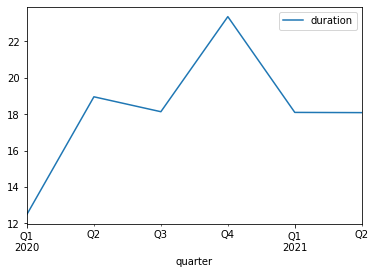

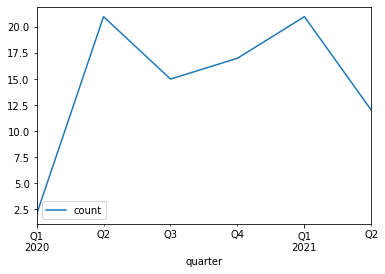

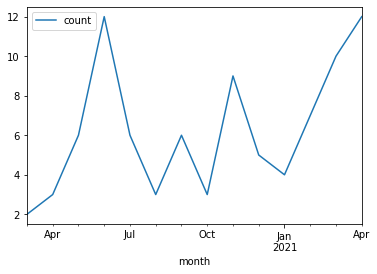

In [43]:
generate_tables_and_charts_by_duration_colum(df, 'duration', True)